In [177]:
''' Importando bibliotecas: '''

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
''' Carregando e normalizando dados de treino'''

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

# 1. Carregar Dados
data, labels = load_data('../../data/digit-recognizer/train.csv')

# 2. Separar entre treino e validação
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# 3. Usar standard scaler para melhorar a análise dos dados
# scaler = StandardScaler()
# data_train_scaled = scaler.fit_transform(data_train)
# data_val_scaled = scaler.fit_transform(data_val)
data_train_scaled = data_train
data_val_scaled = data_val


loading data
train shape: (42000, 784)
labels shape: (42000,)


In [180]:
''' Criando o modelo '''

RANDOM_STATE = 100
K_CLUSTERS_PER_CLASS = 6
VARIANCE_THRESHOLD_PER_CLUSTER = .68
MIN_POINTS_CENTROID = 100

unique_classes = np.unique(labels)
local_pcas = []
centroids = []
n_cluster_components = []

for class_label in unique_classes:
    print(f"Processando a classe {class_label}...")

    # Filtrar os dados da classe atual
    class_data = data[labels == class_label]

    # Calcular o k-means++ com k = número de componentes = número de rótulos únicos
    kmeans = KMeans(n_clusters=K_CLUSTERS_PER_CLASS, init='k-means++', random_state=RANDOM_STATE)
    cluster_labels = kmeans.fit_predict(class_data)    

    # Para cada centroide
    for cluster_idx in range(len(kmeans.cluster_centers_)):
        # Selecionar os pontos do cluster correspondente
        cluster_points = class_data[cluster_labels == cluster_idx]
        
        # Aqui ignoramos os clusters com menos de MIN_POINTS_CENTROID pontos
        if (len(cluster_points) < MIN_POINTS_CENTROID): continue
        
        pca = PCA(n_components=VARIANCE_THRESHOLD_PER_CLUSTER)
        pca.fit(cluster_points)         
        n_cluster_components.append(pca.n_components_)
        
        # Calcular as primeiras duas componentes principais usando PCA
        centroids.append(kmeans.cluster_centers_[cluster_idx])
        local_pcas.append({
            "class_label": class_label,
            "pca": pca
        })
        
print(f'Total de PCAs = {len(n_cluster_components)}')
print(f'Média de components por cluster = {np.mean(n_cluster_components)}')
print(f'Total de components = {np.sum(n_cluster_components)}')

Processando a classe 0...
Processando a classe 1...
Processando a classe 2...
Processando a classe 3...
Processando a classe 4...
Processando a classe 5...
Processando a classe 6...
Processando a classe 7...
Processando a classe 8...
Processando a classe 9...
Total de PCAs = 58
Média de components por cluster = 15.827586206896552
Total de components = 918


0.9748809523809524


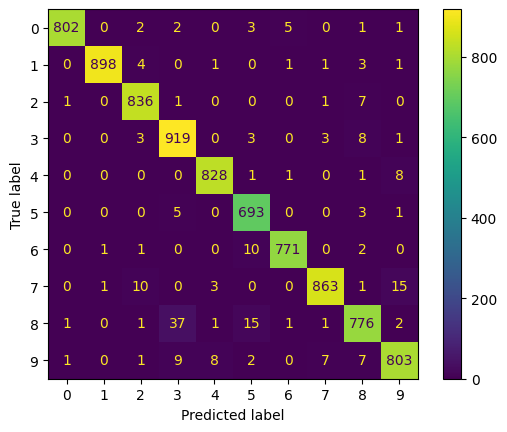

In [181]:
''' Avaliando Performance do modelo '''

def classify_points_with_pca(points, pca_segments):
    """
    Classifica múltiplos pontos usando os PCA calculados em segmentos.
    
    Args:
        points (numpy.ndarray): Array de forma (n_pontos, n_features) com os pontos a serem classificados.
        pca_segments (list): Lista de dicionários, cada um contendo:
                             - 'pca': o modelo PCA treinado.
                             - 'class_label': o rótulo associado ao cluster.
                             
    Returns:
        numpy.ndarray: Array com os rótulos previstos para cada ponto.
    """
    # Obter projeções e reconstruções para todos os pontos e segmentos
    reconstructed_points = np.array([
        pca_segment['pca'].inverse_transform(
            pca_segment['pca'].transform(points)
        )
        for pca_segment in pca_segments
    ])  # Forma: (n_clusters, n_pontos, n_features)
    
    # Calcular os erros de reconstrução para todos os pontos e clusters
    errors = np.linalg.norm(reconstructed_points - points[None, :, :], axis=2)  # Forma: (n_clusters, n_pontos)
    
    # Encontrar o índice do cluster com menor erro para cada ponto
    closest_segment_indices = np.argmin(errors, axis=0)  # Forma: (n_pontos,)
    
    # Mapear os índices aos rótulos das classes
    classifications = np.array([pca_segments[idx]['class_label'] for idx in closest_segment_indices])
    
    return classifications


predictions = classify_points_with_pca(data_val_scaled, local_pcas)
accuracy = accuracy_score(labels_val, predictions)

print(accuracy)

# Melhor conseguido na validação:
# 0.9754761904761905
# Parâmetros:
# RANDOM_STATE = 100
# K_CLUSTERS_PER_CLASS = 6
# VARIANCE_THRESHOLD_PER_CLUSTER = .68
# MIN_POINTS_CENTROID = 100

conf_matrix = confusion_matrix(labels_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [179]:
# Generate Submission

''' Gerar submissão ''' 
file_path = '../../data/digit-recognizer/test.csv' 
test_data = pd.read_csv(file_path)
data_points = test_data.to_numpy()

batch_size = 1000
idx = 0
predictions = np.ones(len(data_points))
while idx < len(data_points):
    print(f"{idx}/{len(data_points)}")
    batch_points = data_points[idx:(idx + batch_size)]
    predictions[idx:(idx + batch_size)] = classify_points_with_pca(batch_points, local_pcas)
    idx += batch_size

test_data.loc[:, "Label"] = predictions.astype(int)
answer = test_data[["Label"]].copy() 
answer["ImageId"] = range(1, len(answer) + 1)  
answer = answer[["ImageId", "Label"]]

# Save to CSV
output_file = f"submission_6_68.csv"
answer.to_csv(output_file, index=False)

0/28000
1000/28000
2000/28000
3000/28000
4000/28000
5000/28000
6000/28000
7000/28000
8000/28000
9000/28000
10000/28000
11000/28000
12000/28000
13000/28000
14000/28000
15000/28000
16000/28000
17000/28000
18000/28000
19000/28000
20000/28000
21000/28000
22000/28000
23000/28000
24000/28000
25000/28000
26000/28000
27000/28000
